In [82]:
import os
import ast
import pytz
import json
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import pandas_profiling

In [83]:
def import_data(filename):
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    name,ext = os.path.splitext(filename)
    if ext == '.csv':
        data = pd.read_csv(filename,low_memory=False,parse_dates= True,infer_datetime_format = True,date_parser = dateparse)
    if ext == '.json':
        data = pd.read_json(filename)
    if ext =='.xlsx' or ext == '.xls':
        data == pd.read_excel(filename)
    return data

In [84]:
train = import_data("/home/divyanka/Downloads/train_s3TEQDk.csv")

In [85]:
test  = import_data("/home/divyanka/Downloads/test_mSzZ8RL.csv")

In [86]:
from sklearn.ensemble import RandomForestClassifier #, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt 
#import statsmodels.formula.api as sm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xg
from xgboost import XGBClassifier 
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
import seaborn as sns
from numpy import set_printoptions
from sklearn import preprocessing

In [87]:
train['Credit_Product'] = train['Credit_Product'].fillna(0)
m = train['Credit_Product'].mode()
train['Credit_Product'] = train['Credit_Product'].replace(0,m.iloc[0])

In [88]:
test['Credit_Product'] = test['Credit_Product'].fillna(0)
m = test['Credit_Product'].mode()
test['Credit_Product'] = test['Credit_Product'].replace(0,m.iloc[0])

In [89]:
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
le=LabelEncoder()

# Iterate over all the values of each column and extract their dtypes
for col in train.columns:
    # Compare if the dtype is object
    if col == 'ID':
        continue
    if train[col].dtypes=='object':
        print(col)
    # Use LabelEncoder to do the numeric transformation
        train[col]=le.fit_transform(train[col])

Gender
Region_Code
Occupation
Channel_Code
Credit_Product
Is_Active


In [90]:
for col in test.columns:
    # Compare if the dtype is object
    if col == 'ID':
        continue
    if test[col].dtypes=='object':
        print(col)
    # Use LabelEncoder to do the numeric transformation
        test[col]=le.fit_transform(test[col])

Gender
Region_Code
Occupation
Channel_Code
Credit_Product
Is_Active


In [91]:
train_ = train.drop('ID',axis=1)

In [93]:
X= train_.loc[:, train_.columns != 'Is_Lead']
y = train_.loc[:, train_.columns == 'Is_Lead']

In [94]:
sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1)   
X_smote, y = sm.fit_resample(X, y)


/home/divyanka/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [98]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_smote = sc.fit_transform(X_smote)

In [101]:
X_smote

array([[-0.97290698,  1.97003922, -0.21058897, ..., -0.56920777,
        -0.12846768, -0.70149921],
       [-0.97290698, -1.14394409,  0.66880783, ..., -0.56920777,
        -0.67094288, -0.70149921],
       [-0.97290698,  0.73892954, -0.21058897, ..., -0.56920777,
         0.3846568 ,  1.42551835],
       ...,
       [-0.97290698,  1.31827527,  1.1573616 , ..., -0.56920777,
        -0.83865924, -0.70149921],
       [ 1.02784749,  0.30442024,  0.66880783, ..., -0.56920777,
         0.22235224, -0.70149921],
       [ 1.02784749, -0.78185301,  0.66880783, ..., -0.56920777,
        -0.02351101, -0.70149921]])

In [102]:
x_train, x_valid, y_train, y_valid = train_test_split(X_smote, y, test_size=0.2, random_state = 42)

In [103]:
xgb = XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(x_train, y_train)

/home/divyanka/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:29:36] WARNING: /tmp/pip-install-h266q8hf/xgboost/build/temp.linux-x86_64-3.7/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [106]:
y_pred_ = xgb.predict(x_valid)

# Get the accuracy score of logreg model and print it
print("Accuracy of xgboost classifier: ",xgb.score(x_valid,y_valid))

Accuracy of xgboost classifier:  0.7916238746248749


In [107]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_valid,y_pred_))

0.7915746039003686


In [108]:
test_ = test.drop('ID',axis=1)
test_ = sc.fit_transform(test_)
test_pred = xgb.predict(test_)
ID = test['ID']
submission_df = pd.DataFrame({'ID':ID,'Is_Lead':test_pred})

In [109]:
submission_df.Is_Lead.value_counts()

0    64124
1    41188
Name: Is_Lead, dtype: int64

In [110]:
submission_df.to_csv('/home/divyanka/Downloads/balanced_xgboost.csv',index=False)

In [12]:
selector = SelectKBest(score_func=chi2,k='all')

In [13]:
X_new = selector.fit_transform(X_train, y_train)
names = X_train.columns.values[selector.get_support()]
scores = selector.scores_[selector.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

            Feat_names      F_Scores
7  Avg_Account_Balance  2.684467e+08
5              Vintage  2.902719e+05
1                  Age  4.436462e+04
4         Channel_Code  9.858431e+03
2          Region_Code  3.557893e+03
6       Credit_Product  1.626158e+03
8            Is_Active  7.533744e+02
0               Gender  4.231207e+02
3           Occupation  7.748473e+00


In [14]:
train_ = train.groupby(['Is_Active','Credit_Product']).mean().reset_index()

In [15]:
train_.head()

,Is_Active,Credit_Product,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Avg_Account_Balance,Is_Lead
0,0,0,0.502246,39.322132,18.870439,2.026709,0.573938,39.521668,1.041173e+06,0.187959
1,0,1,0.557467,45.169208,20.331311,2.098846,1.032616,45.641523,1.146595e+06,0.248533
2,1,0,0.573384,47.106790,20.443190,2.187903,1.111376,52.416873,1.187568e+06,0.228140
3,1,1,0.629301,50.675006,21.497881,2.179631,1.410162,65.646617,1.286995e+06,0.466576


In [16]:
from functools import partial


def corr_heatmap(dataframe, cmap=sns.diverging_palette(220, 10, as_cmap=True),
                 **kwargs):
    """
    :param dataframe: a pandas DataFrame
    :param cmap: color map to feed into sns.heatmap
    :param kwargs: kwargs to feed into sns.heatmap
    :return: fig, ax
    """
    corr = dataframe.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    # np.triu_indices_from returns the indices for the upper-triangle of mask
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(11, 9))

    # Draw the heatmap with the mask and correct aspect ratio
    masked_heatmap = partial(sns.heatmap, mask=mask, cmap=cmap, vmax=0.3,
                             center=0, linewidths=0.5, square=True,
                             cbar_kws={"shrink": 0.5})
    ax = masked_heatmap(corr, **kwargs)
    return fig, ax

(<Figure size 792x648 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3272100550>)

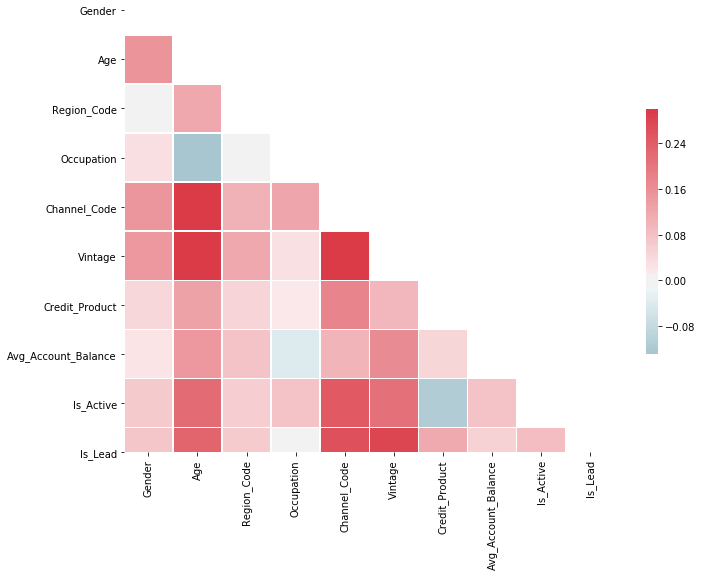

In [17]:
corr_heatmap(train)

(<Figure size 792x648 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f327440d128>)

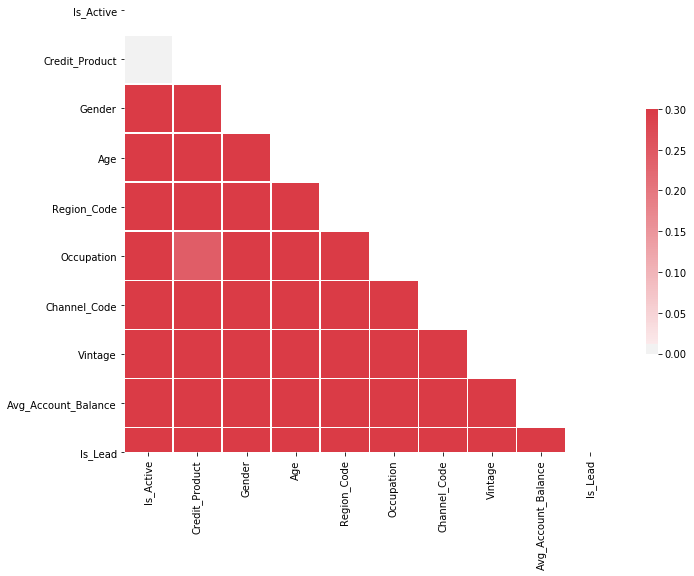

In [18]:
corr_heatmap(train_)

In [29]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test,y_pred_))

0.6582109249884379


In [38]:
test_ = test.drop('ID',axis=1)
test_ = scaler.fit_transform(test_)
test_pred = clf.predict(test_)
ID = test['ID']
submission_df = pd.DataFrame({'ID':ID,'Is_Lead':test_pred})

In [35]:
test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [33]:
test_

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,1,29,4,1,0,25,1,742366,0
1,1,43,18,1,1,49,0,925537,0
2,1,31,20,2,0,14,0,215949,0
3,1,29,22,1,0,33,0,868070,0
4,0,29,20,1,0,19,0,657087,0
5,1,60,18,3,2,110,0,4624262,0
6,0,69,3,1,1,67,0,1032764,0
7,0,30,7,2,0,33,0,837009,0
8,1,43,34,2,2,81,0,1001232,1
9,0,54,33,3,1,37,1,1667851,0


In [39]:
submission_df.Is_Lead.value_counts()

0    55485
1    49827
Name: Is_Lead, dtype: int64

In [40]:
submission_df.to_csv('/home/divyanka/Downloads/balanced_svc.csv',index=False)

In [20]:
pipelines = {
    "svc": make_pipeline(SVC())
}

In [ ]:
#To check the accuracy of the pipeline
scores_ = cross_validate(pipelines['svc'],rescaledX_train,y_train,return_train_score=True)
scores_['test_score'].mean()

/home/divyanka/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/divyanka/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
pipelines['svc'].get_params().keys()

In [ ]:
Lightgbm